In [1]:
from IPython.display import display, HTML

display(HTML(data="""

<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

%reload_ext jupyternotify

#%notify

<IPython.core.display.Javascript object>

In [2]:
import sys

import numpy as np
import qutip as qtp
import matplotlib.pyplot as plt

import time
import datetime
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib notebook
plt.rcParams['figure.figsize'] = (10, 7)

In [3]:
import pysqkit.tomography.utilsTomo as tomo

# Description of Tomography Process

## $\{ \rho_i \}$

We take the following convention : 
$$\text{The } \left\{ \rho_i \right\} \text{ are the } \left|n\right>\left<m\right| \text{ ; } n,m \in [\![0, \text{d} ]\!]^2 $$
$$ \text{For 2 systems : the } \left\{ \left|n\right> \right\} \text{are the} \left|ab\right> \text{ ; } a,b \in [\![0, \textit{nb_levels}[0] ]\!] \times [\![0, \textit{nb_levels}[1] ]\!] $$

 
R) d is the total number of levels : $d = \prod _{i} \textit{nb_levels}[i]$ 
In the case of quBits, $d = 2^n$ with $n$ being the number of qubits in the system.  \
For quDits having k levels, it is $d = k^n$



R) There are $d^2$ terms in the $\left\{\rho_i\right\}$ family and each of them has $d^2$ components

## $\{ \tilde{E_i} \}$

We take the following convention : \
$\{\tilde{E_i} \}$ is the basis for operators. There are $d^2$ of them and each has $d^2$ components.

Usually when there are 2 levels, we take Pauli matrices and tensor product of pauli matrices. \
For higher levels we will use Generalized Gell-Mann matrices.

If $P_j ; (j=1...d)$ is the basis for a L levels qudit then ($d=L^2$) : 
$$\forall i \in [\![1, d^2 ]\!] , \exists! j,k \in [\![1, d]\!]^2 \text{ so that } \tilde{E_i} = P_j\otimes P_k$$


## $\textit{fct_to_lambda(...)}$

$$\lambda \in d^2 \times d^2 \text{ is the matrix defined by : } \mathcal{E} (\rho_j) = \sum_k \lambda_{jk} \rho_k \text{    ($\mathcal{E}$ is the gate)}$$

## $\textit{lambda_to_chi(...)}$

The $\chi$ matrix for a basis $\left\{ \tilde{E_i} \right\}$ of operators is defined by the following formula :

$$\mathcal{E}(\rho) = \sum_{mn} \chi_{mn} \tilde{E_m}\rho\tilde{E_n}^\dagger$$

Some examples of $\chi$ matrices :

For 1 qubits : X operator $$\chi_X = \begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0
\end{bmatrix}$$

For 2 qubits : $U_{CNOT} = I\otimes I + I\otimes X + Z\otimes I - Z\otimes Z$ donc : 
$$\chi_{CNOT} = \begin{bmatrix}
 1 &  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  1 & -1 & 0 & 0 \\
 1 &  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  1 & -1 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 1 &  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  1 & -1 & 0 & 0 \\
-1 & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 &  1 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0
\end{bmatrix}$$

## $\textit{lambda} \leftrightarrow \textit{chi}$  through  $ \beta$

The $\beta$ matix is defined as follows :  
$$\tilde{E_m} \rho_j \tilde{E_n}^{\dagger} = \sum_k \beta_{jk}^{mn}  \rho_k $$
$$ m,n \in \left[\!\left[1,d^2\right]\!\right]^2 \text{  and  } j,k \in \left[\!\left[1,d^2\right]\!\right]^2$$

So if follows : 
$$\beta_{jk}^{mn} = Tr \left\{ \tilde{E_m} \rho_j \tilde{E_n}^{\dagger} \rho_k^{\dagger} \right\} $$

We choose to index $\beta$ as a matrix with rows labeled $(j,k)=\mu$ and columns labeled $(m,n) = \nu$. \
$\beta \in d^4 \times d^4$

We test 8.158 to check if the $\chi$ matrix coincides qith the caculated $\beta$ and $\lambda$:

With our convention of $\mu = (j,k)$ ans $\nu = (m,n)$ , this equation is : 
$$\sum_{\nu} \beta_{\mu}^{\nu} \chi_{\nu} = \lambda_{\mu} \ ; \ \forall \mu \in [\![ 1, d^4]\!]$$

R) The left side of this equation is labelled $\textit{lambda_th_mat}$ or $\lambda_{ij}^{th}$

## $\textit{chi_to_kraus(...)}$

We use the formula 8.168 from Nielsen and Chuang : 

$$ E_i = \sqrt{d_i}\sum_j U_{ij} \tilde{E_j}$$ 

$$ \text{  with  } U \text{  such that  } \chi = UDU^\dagger \text{ ; } U \text{ unitary and } D \text{ diagonal }$$

# Tutorial

## Defining a function

In [22]:
#From a U matrix :

#Set U
U_CNOT = np.zeros((4,4))
U_CNOT[0,0] = 1
U_CNOT[1,1] = 1
U_CNOT[2,3] = 1
U_CNOT[3,2] = 1
U_CNOT = qtp.Qobj(U_CNOT, dims = [[2,2], [2, 2]])

U_id = qtp.qeye([2,2])

U_0 = qtp.Qobj(np.zeros((4,4)), dims = [[2,2], [2,2]])

sigmai = qtp.sigmax()
sigmaj = qtp.sigmaz()
U_i_j = qtp.tensor(sigmai, sigmaj)

nb_levels = [3,2]

U_rand = qtp.Qobj(2*(np.random.rand(nb_levels[0]*nb_levels[1], nb_levels[0]*nb_levels[1])-.5) + \
                  2j*(np.random.rand(nb_levels[0]*nb_levels[1], nb_levels[0]*nb_levels[1])-.5), 
                   dims = [nb_levels, nb_levels]).unit() #qtp.qeye([2]*mult)


#Use the build in constructor
U = U_rand
fct_U = tomo.rid_of_dict(tomo._gate_from_U, {'U' : U}) #fct_U takes only an initial state

# fct_U(qtp.fock_dm([2,2], [1, 0]))

In [6]:
#From a set of Kraus operators :

#Set list of operators
nb_levels = [2,2] #[2,2]
d = np.prod(nb_levels)

op_list_id = [qtp.qeye(nb_levels)]

op_list_random = [qtp.Qobj(2*(np.random.rand(d, d)-.5) + 2j*(np.random.rand(d, d)-.5), 
                   dims = [nb_levels, nb_levels]) for i in range(d**2)]

op_list_xyz = [qtp.tensor(qtp.qeye(2), qtp.sigmax()), 
               qtp.tensor(qtp.qeye(2), qtp.sigmay()),
               qtp.tensor(qtp.qeye(2), qtp.sigmaz())]

#Use the build in constructor
op_list = op_list_id
fct_Kraus = tomo.rid_of_dict(tomo._gate_from_Kraus, {'op_list' : op_list})

fct_Kraus(qtp.fock_dm([2,2], [1,0]))

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]

In [7]:
#From a simulation based process : 

#fct_simu = tomo.rid_of_dict("function automating the simulation process", "paramaters needed for this simulation")
#the result only takes an initial state

## Tomography

In [23]:
fct = fct_U

<IPython.core.display.Javascript object>


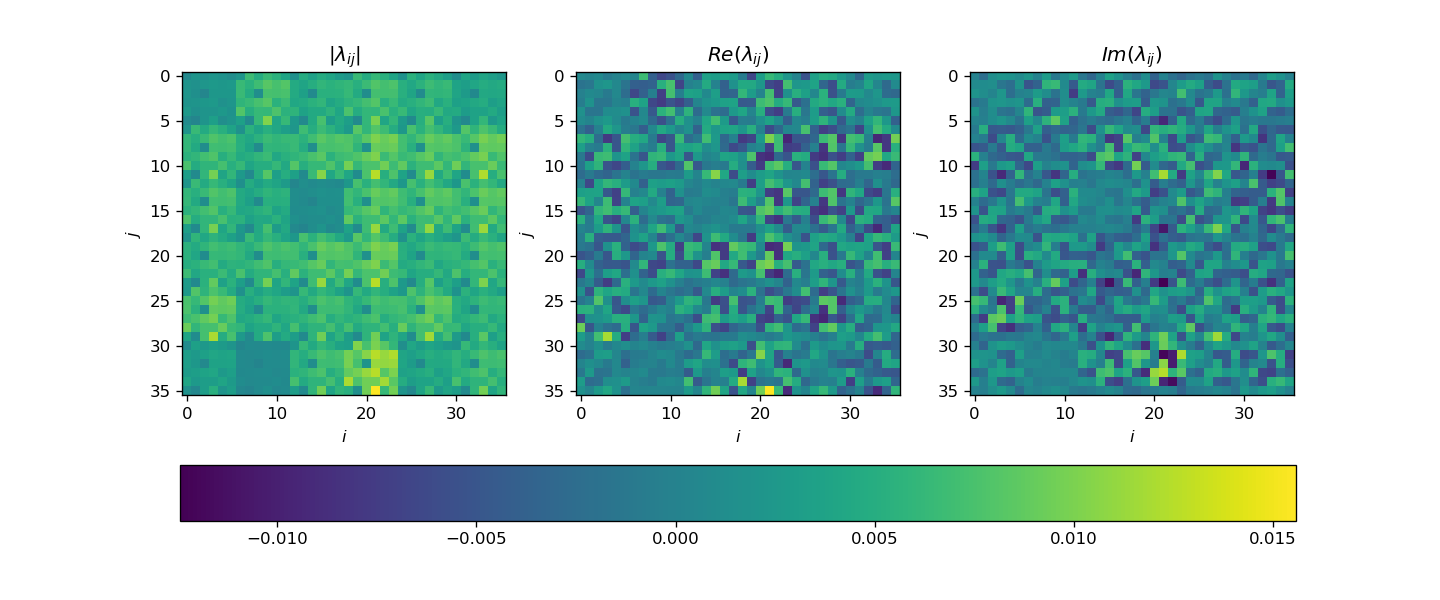

It took 1.4129986763000488 seconds


In [24]:
deb =  time.time()
lambda_mat = tomo.fct_to_lambda(fct, nb_levels, draw_lambda = True)
print("It took" , time.time() - deb, "seconds")

<IPython.core.display.Javascript object>


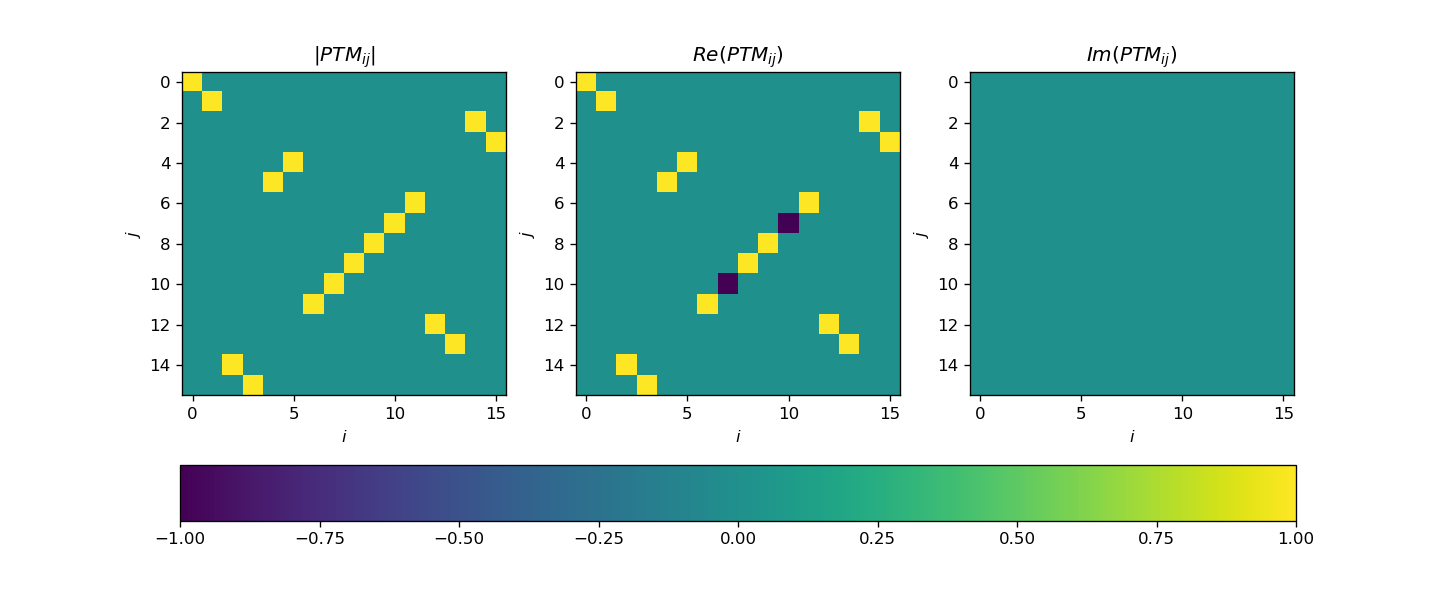

It took 0.26099419593811035 seconds


In [7]:
deb =  time.time()
PTM_mat = tomo.fct_to_PTM(fct, nb_levels, draw_PTM = True)
print("It took" , time.time() - deb, "seconds")

<IPython.core.display.Javascript object>


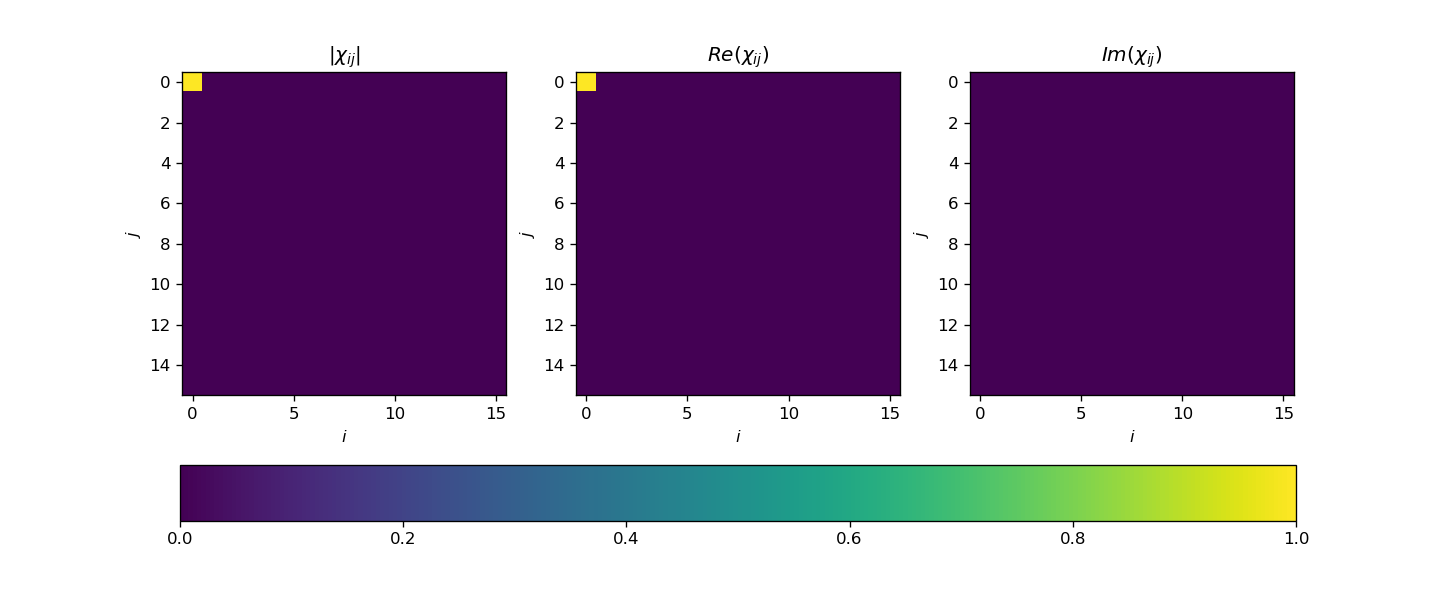

It took 0.24899935722351074 seconds


In [11]:
deb =  time.time()
chi_mat = tomo.lambda_to_chi(lambda_mat, nb_levels, draw_chi = True )
print("It took" , time.time() - deb, "seconds")

<IPython.core.display.Javascript object>


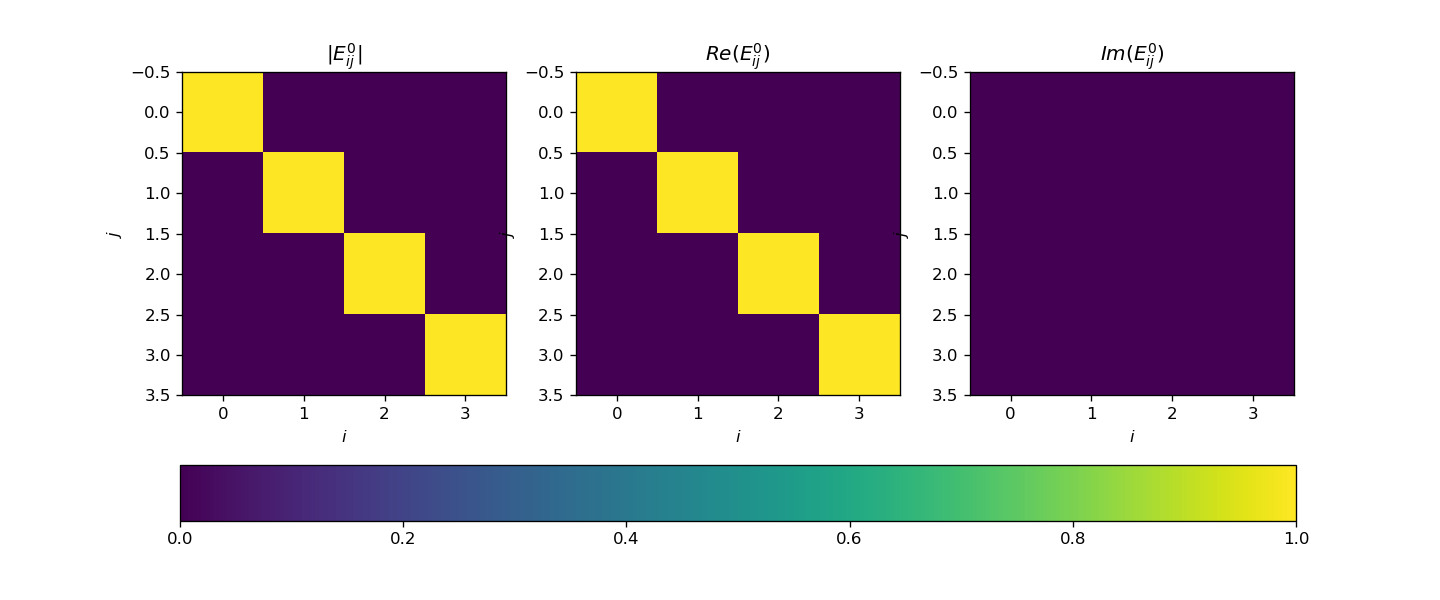

It took 0.184967041015625 seconds


In [12]:
deb = time.time()
kraus_list = tomo.chi_to_kraus(chi_mat, nb_levels, draw_kraus = True)
print("It took" , time.time() - deb, "seconds")

<IPython.core.display.Javascript object>


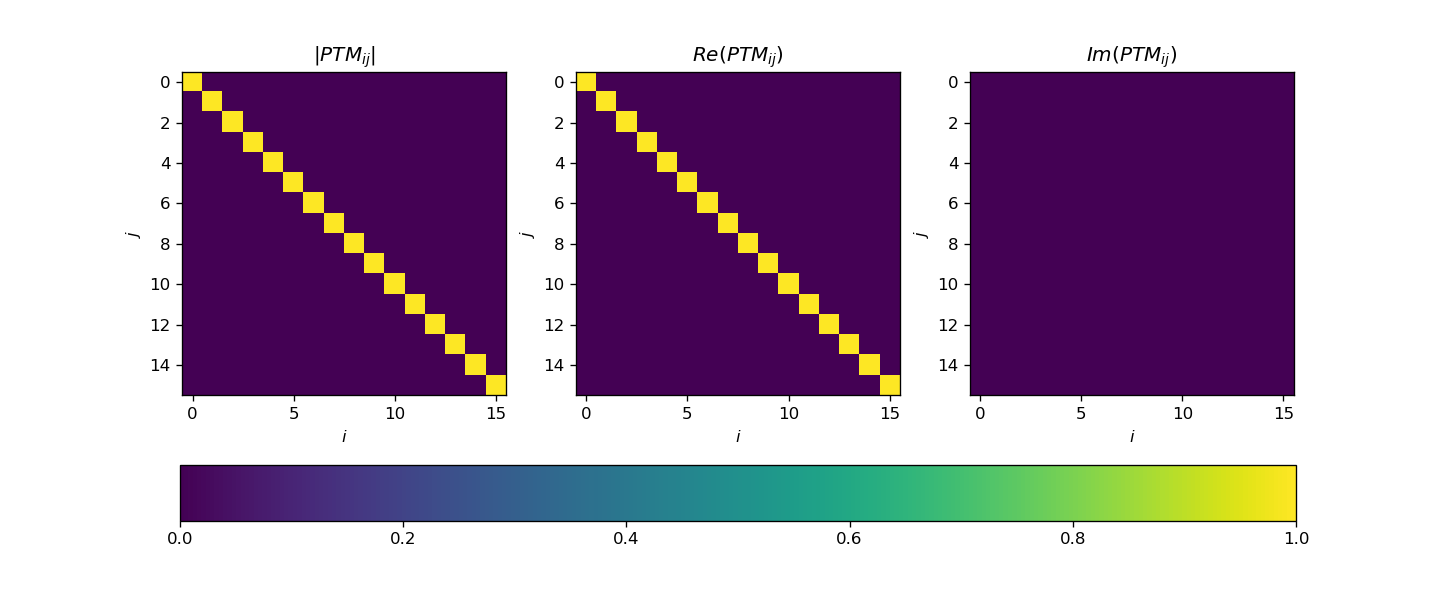

It took 2.5052852630615234 seconds


In [13]:
deb = time.time()
PTM_mat_from_chi = tomo.chi_to_PTM(chi_mat, nb_levels, draw_PTM = True)
print("It took" , time.time() - deb, "seconds")

<IPython.core.display.Javascript object>


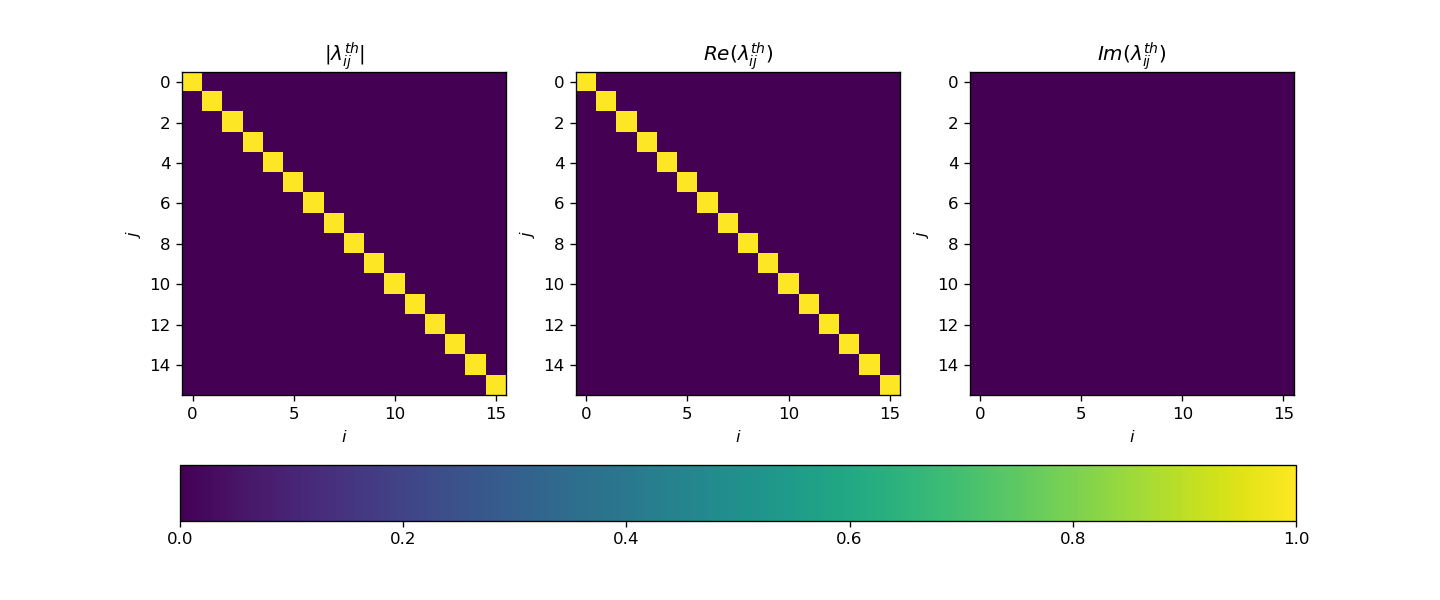

It took 156.05575513839722 seconds


<IPython.core.display.Javascript object>


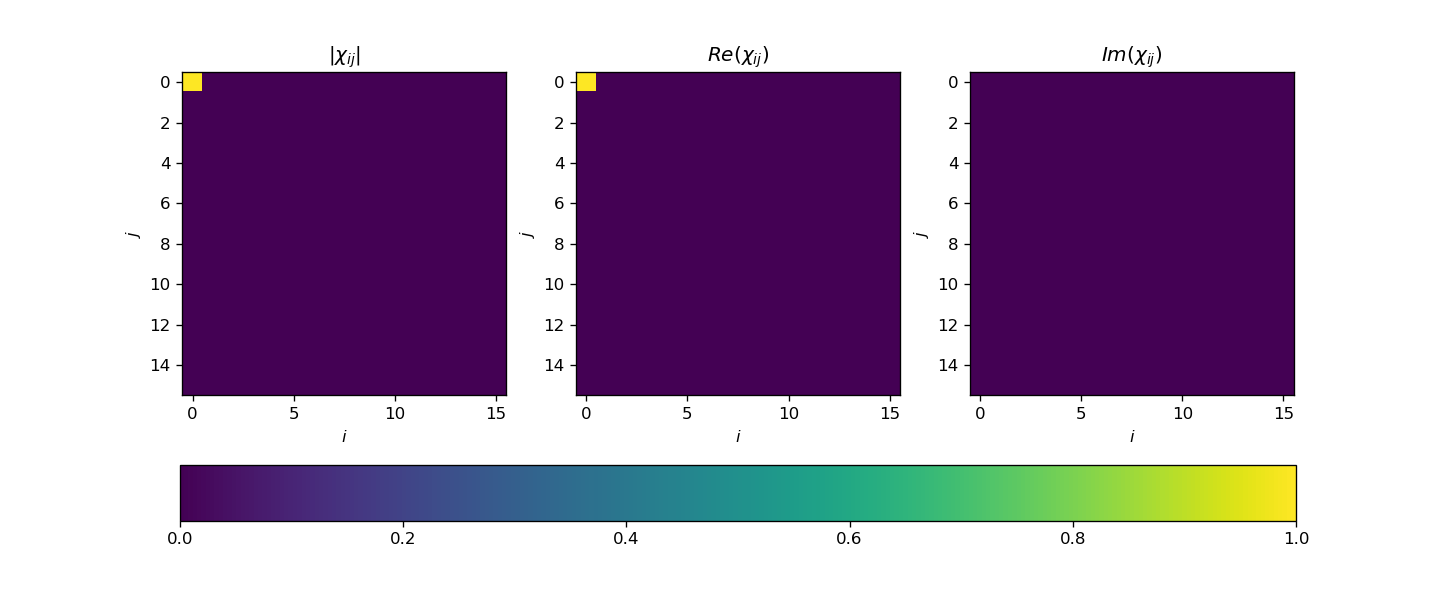

It took 0.24499821662902832 seconds


In [14]:
#tests using beta, very costly in complexity
deb = time.time()
lambda_mat_from_beta = tomo.chi_to_lambda_beta(chi_mat, nb_levels, draw_lambda = True)
print("It took" , time.time() - deb, "seconds")

deb = time.time()
chi_mat_from_beta = tomo.lambda_to_chi_beta(lambda_mat, nb_levels, draw_chi = True)
print("It took" , time.time() - deb, "seconds")